In [ ]:
from typing import List
import sys
import os

sys.path.append(os.path.abspath(".."))
from nmr_spectrum import NMRSpectrum
from spectrum import Spectrum

from matplotlib import pyplot as plt

import numpy as np

components_names = ["Pinene", "Benzyl benzoate"]

protons_list = [16, 12]

filename = "preprocessed_mix.csv"
mix = np.loadtxt(filename, delimiter=",")
# If you are using file exported from Mnova, comment line above and uncomment line below.
# mix = np.loadtxt(filename, delimiter='\t', usecols=[0,1])

how_many_components = len(components_names)
names = ["comp" + str(i) for i in range(how_many_components)]

files_with_components = ["preprocessed_comp0.csv", "preprocessed_comp1.csv"]
spectra = []
for i in range(how_many_components):
    filename = files_with_components[i]
    spectra.append(np.loadtxt(filename, delimiter=","))
    # If you are using file exported from Mnova, comment line above and uncomment line below.
    # spectra.append(np.loadtxt(filename, delimiter='\t', usecols=[0,1]))

spectra2: List[NMRSpectrum] = []
names = []
for i in range(len(spectra)):
    spectra2.append(
        NMRSpectrum(
            confs=list(zip(spectra[i][:, 0], spectra[i][:, 1])), protons=protons_list[i]
        )
    )
    names.append("comp" + str(i))

spectra = spectra2
del spectra2
mix = NMRSpectrum(confs=list(zip(mix[:, 0], mix[:, 1])))
mix.trim_negative_intensities()
mix.normalize()
for sp in spectra:
    sp.trim_negative_intensities()
    sp.normalize()
plt.title("Mixture")
mix.plot(profile=True)


def generate_synthetic_mixture(components, true_p):
    """Generate a synthetic mixture from components based on given proportions."""
    # Create mixture using ScalarProduct
    synthetic_mix = Spectrum.ScalarProduct(components, true_p)
    synthetic_mix.normalize()
    return synthetic_mix


# p = 0.4  # 0.01 # 0.3
# # p = 0.5
# calculated_mix = generate_synthetic_mixture(spectra, [p, 1 - p])
# calculated_mix.normalize()

# plt.title(f"Synthetic Mixture [{p}, {1 - p}]")
# calculated_mix.plot(profile=True)

for i, sp in enumerate(spectra):
    plt.title("Component " + str(i))
    sp.plot(profile=True)
print(spectra[0].confs[:10])


# Użyć unbalanced optimal transport zamiast wassersteina z total variation karą

# Flat metric


In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar

c0 = pd.read_csv("/mnt/data/preprocessed_comp0.csv", header=None).iloc[:, 1].values
c1 = pd.read_csv("/mnt/data/preprocessed_comp1.csv", header=None).iloc[:, 1].values
m = pd.read_csv("/mnt/data/preprocessed_mix.csv", header=None).iloc[:, 1].values


def loss(a):
    return np.sum((m - (a * c0 + (1 - a) * c1)) ** 2)


res = minimize_scalar(loss, bounds=(0, 1), method="bounded")
print(res.x)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/preprocessed_comp0.csv'

In [ ]:
import numpy as np
import pandas as pd

c0 = pd.read_csv('preprocessed_comp0.csv', header=None).iloc[:,1].values
c1 = pd.read_csv('preprocessed_comp1.csv', header=None).iloc[:,1].values
m  = pd.read_csv('preprocessed_mix.csv',   header=None).iloc[:,1].values

alpha = np.dot(m - c1, c0 - c1) / np.dot(c0 - c1, c0 - c1)
print(alpha)


In [ ]:
import numpy as np
from tqdm import trange
import math


def WSDistanceMoves(first, second):
    """Return the optimal transport plan between self and other."""
    try:
        ii = 0
        leftoverprob = second.confs[0][1]
        for mass, prob in first.confs:
            while leftoverprob <= prob:
                yield (second.confs[ii][0], mass, leftoverprob)
                prob -= leftoverprob
                ii += 1
                leftoverprob = second.confs[ii][1]
            yield (second.confs[ii][0], mass, prob)
            leftoverprob -= prob
    except IndexError:
        return


def WSDistance(first, second):
    """
    Compute Wasserstein distance using only n most significant features.
    If n_features is None, use all features.
    """

    if not np.isclose(sum(x[1] for x in first.confs), 1.0):
        raise ValueError("Self is not normalized.")
    if not np.isclose(sum(x[1] for x in second.confs), 1.0):
        raise ValueError("Other is not normalized.")

    return math.fsum((x[0] - x[1]) * x[2] for x in WSDistanceMoves(first, second))

import ot


def filter_significant_features(first, second, n_features):
    """
    Select the n most significant features from both spectra.
    Uses combined intensity to determine importance.
    """
    # Create dictionary with combined intensities
    combined_intensities = {}
    for mz, prob in first.confs:
        combined_intensities[mz] = combined_intensities.get(mz, 0) + prob
    for mz, prob in second.confs:
        combined_intensities[mz] = combined_intensities.get(mz, 0) + prob

    # Select top n features
    selected_features = set(
        sorted(
            combined_intensities.keys(),
            key=lambda mz: combined_intensities[mz],
            reverse=True,
        )[:n_features]
    )

    # Filter spectra
    filtered_first = first.copy()
    filtered_first.confs = [
        (mz, prob) for mz, prob in first.confs if mz in selected_features
    ]

    filtered_second = second.copy()
    filtered_second.confs = [
        (mz, prob) for mz, prob in second.confs if mz in selected_features
    ]

    # Re-normalize
    filtered_first.normalize()
    filtered_second.normalize()

    return filtered_first, filtered_second

def unbalanced_ot_distance(first, second, reg_m=5.0, reg_div='kl', regm_div='tv'):
    """Compute scalar unbalanced OT distance (with TV penalty) between two NMRSpectra."""
    x1 = np.array([mz for mz, inten in first.confs])
    x2 = np.array([mz for mz, inten in second.confs])
    a = np.array([inten for mz, inten in first.confs])
    b = np.array([inten for mz, inten in second.confs])

    # Cost matrix: squared Euclidean distance between m/z positions
    M = ot.utils.dist(x1.reshape(-1, 1), x2.reshape(-1, 1))**2

    # Use lbfgsb_unbalanced2 to get the scalar cost directly
    cost = ot.unbalanced.lbfgsb_unbalanced2(
        a, b, M, reg=0.0, reg_m=reg_m,
        reg_div=reg_div, regm_div=regm_div,
        returnCost='linear'  # returns scalar objective value
    )

    return cost

def calculate_gradient(mix, comp0, comp1, p, epsilon=1e-5):
    delta = epsilon

    p_plus = np.array([p[0] + delta, p[1] - delta])
    p_minus = np.array([p[0] - delta, p[1] + delta])

    p_plus = np.clip(p_plus, 1e-6, 1)
    p_plus /= p_plus.sum()

    p_minus = np.clip(p_minus, 1e-6, 1)
    p_minus /= p_minus.sum()

    sp_plus = Spectrum.ScalarProduct([comp0, comp1], p_plus)
    sp_minus = Spectrum.ScalarProduct([comp0, comp1], p_minus)

    sp_plus.normalize()
    sp_minus.normalize()

    grad = (mix.WSDistance(sp_plus) - mix.WSDistance(sp_minus)) / (2 * epsilon)

    # Gradient of p[1] is -grad because p[1] = 1 - p[0]
    grad_vec = np.array([grad, -grad])

    return grad_vec


def mirror_descent_two_weights(
    mix, comp0, comp1, learning_rate=1.0, T=100, epsilon=1e-5, lmd=0.99
):
    p = np.array([0.5, 0.5])  # start from uniform mixture
    history = [p.copy()]
    scores = []

    for _ in trange(T, desc="Mirror Descent (2 weights)"):
        # Track score (distance from current estimate to true mixture)
        estimated_mix = Spectrum.ScalarProduct([comp0, comp1], p)
        estimated_mix.normalize()
        ws = unbalanced_ot_distance(mix, estimated_mix)

        scores.append(ws)

        # Compute gradient
        grad_vec = calculate_gradient(mix, comp0, comp1, p, epsilon)

        # Mirror descent update
        w = p * np.exp(-learning_rate * grad_vec)
        p = w / w.sum()
        learning_rate *= lmd
        history.append(p.copy())

    return p, np.array(history), np.array(scores)


# Run mirror descent
mix.normalize()
spectra[0].normalize()
spectra[1].normalize()

final_p, traj, score_history = mirror_descent_two_weights(
    mix, spectra[0], spectra[1], learning_rate=0.0005, T=50
)

# Reconstruct mixture from estimated weights
estimated_mix = Spectrum.ScalarProduct([spectra[0], spectra[1]], final_p)
estimated_mix.normalize()

# Compute Wasserstein distance to the actual mixture
ws_dist = unbalanced_ot_distance(mix, estimated_mix)


# Compute Wasserstein distance for the given mixture
given_p = np.array([0.393072, 0.606928])
given_mix = Spectrum.ScalarProduct([spectra[0], spectra[1]], given_p)
given_mix.normalize()
ws_dist_given = unbalanced_ot_distance(mix, given_mix)


# Print results
print("\nFinal weights:")
print(f"  comp1 = {final_p[0]:.4f}")
print(f"  comp2 = {final_p[1]:.4f}")
print(f"\nFinal Wasserstein distance to true mixture: {ws_dist:.6f}")
print(
    f"\nWasserstein distance for given mixture (0.393072, 0.606928): {ws_dist_given:.6f}"
)

plt.plot(traj[:, 0], label="Component 0")
plt.plot(traj[:, 1], label="Component 1")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.title("Mirror Descent Weight Evolution")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(score_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Wasserstein Distance")
plt.title("Distance to True Mixture Over Iterations")
plt.grid(True)
plt.show()


Mirror Descent (2 weights):   0%|          | 0/50 [00:00<?, ?it/s]


MemoryError: Unable to allocate 73.7 GiB for an array with shape (70340, 140680) and data type float64

In [22]:
import numpy as np
import ot
from typing import List, Tuple
from tqdm import trange


# --- Filtering: pick only top-N features from both spectra ---
def filter_significant_features(first, second, n_features: int):
    combined_intensities = {}
    for mz, prob in first.confs:
        combined_intensities[mz] = combined_intensities.get(mz, 0) + prob
    for mz, prob in second.confs:
        combined_intensities[mz] = combined_intensities.get(mz, 0) + prob

    selected_features = set(
        sorted(
            combined_intensities.keys(),
            key=lambda mz: combined_intensities[mz],
            reverse=True,
        )[:n_features]
    )

    filtered_first = first.copy()
    filtered_first.confs = [
        (mz, prob) for mz, prob in first.confs if mz in selected_features
    ]

    filtered_second = second.copy()
    filtered_second.confs = [
        (mz, prob) for mz, prob in second.confs if mz in selected_features
    ]

    filtered_first.normalize()
    filtered_second.normalize()

    return filtered_first, filtered_second


# --- Local sparse cost matrix ---
def build_sparse_cost_matrix(x1: np.ndarray, x2: np.ndarray, window: float = 0.1):
    n, m = len(x1), len(x2)
    M = np.full((n, m), 1e6)
    for i in range(n):
        for j in range(m):
            if abs(x1[i] - x2[j]) <= window:
                M[i, j] = (x1[i] - x2[j]) ** 2
    return M


# --- Unbalanced OT distance computation ---
def unbalanced_ot_distance(
    first,
    second,
    reg_m: float = 5.0,
    reg_div: str = "kl",
    regm_div: str = "tv",
    n_features: int = 50,
    window: float = 0.1,
) -> float:
    first, second = filter_significant_features(first, second, n_features)

    x1 = np.array([mz for mz, inten in first.confs])
    x2 = np.array([mz for mz, inten in second.confs])
    a = np.array([inten for mz, inten in first.confs])
    b = np.array([inten for mz, inten in second.confs])

    M = build_sparse_cost_matrix(x1, x2, window)

    cost = ot.unbalanced.lbfgsb_unbalanced2(
        a,
        b,
        M,
        reg=0.0,
        reg_m=reg_m,
        reg_div=reg_div,
        regm_div=regm_div,
        returnCost="linear",
    )

    return cost


# --- Gradient estimation for mirror descent ---
def calculate_uot_gradient(mix, comp0, comp1, p, epsilon=1e-5):
    delta = epsilon

    p_plus = np.array([p[0] + delta, p[1] - delta])
    p_minus = np.array([p[0] - delta, p[1] + delta])

    p_plus = np.clip(p_plus, 1e-6, 1)
    p_plus /= p_plus.sum()
    p_minus = np.clip(p_minus, 1e-6, 1)
    p_minus /= p_minus.sum()

    sp_plus = Spectrum.ScalarProduct([comp0, comp1], p_plus)
    sp_minus = Spectrum.ScalarProduct([comp0, comp1], p_minus)
    sp_plus.normalize()
    sp_minus.normalize()

    grad = (
        unbalanced_ot_distance(mix, sp_plus) - unbalanced_ot_distance(mix, sp_minus)
    ) / (2 * epsilon)
    grad_vec = np.array([grad, -grad])

    return grad_vec


# --- Mirror descent ---
def mirror_descent_two_weights_uot(
    mix, comp0, comp1, learning_rate=1.0, T=100, epsilon=1e-5, lmd=0.99
):
    p = np.array([0.5, 0.5])
    history = [p.copy()]
    scores = []

    for _ in trange(T, desc="Mirror Descent (UOT)"):
        estimated_mix = Spectrum.ScalarProduct([comp0, comp1], p)
        estimated_mix.normalize()
        score = unbalanced_ot_distance(mix, estimated_mix)
        scores.append(score)

        grad_vec = calculate_uot_gradient(mix, comp0, comp1, p, epsilon)

        w = p * np.exp(-learning_rate * grad_vec)
        p = w / w.sum()
        learning_rate *= lmd
        history.append(p.copy())

    return p, np.array(history), np.array(scores)

final_p, traj, score_history = mirror_descent_two_weights_uot(
    mix, spectra[0], spectra[1], learning_rate=0.001, T=50
)


Mirror Descent (UOT):   6%|▌         | 3/50 [00:09<02:27,  3.14s/it]


KeyboardInterrupt: 

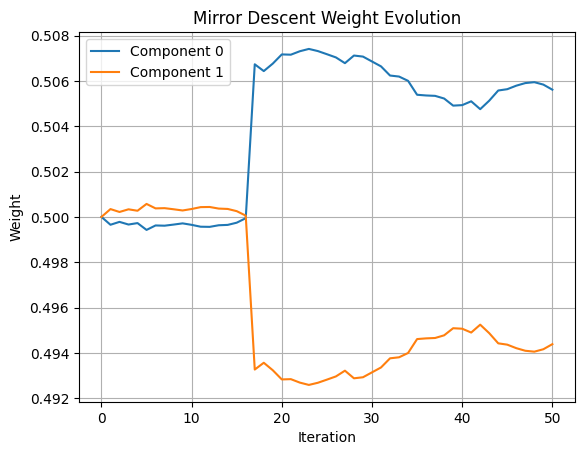

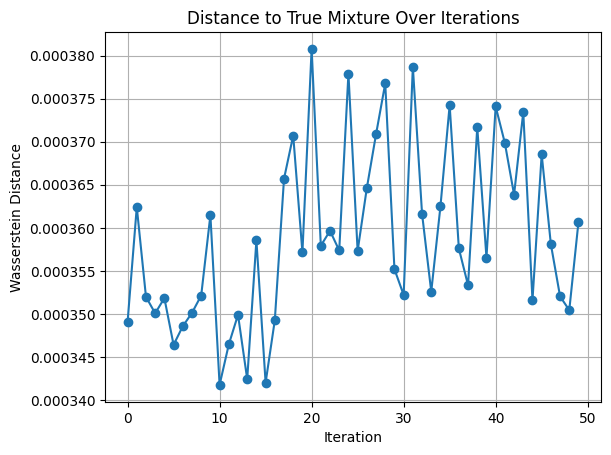

In [20]:
plt.plot(traj[:, 0], label="Component 0")
plt.plot(traj[:, 1], label="Component 1")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.title("Mirror Descent Weight Evolution")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(score_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Wasserstein Distance")
plt.title("Distance to True Mixture Over Iterations")
plt.grid(True)
plt.show()
